In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True

In [2]:
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"]
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# WATCH SENSORS
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")

# PHONE SENSORS
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

# MERGE – use OUTER so we don’t lose rows
df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

print(df_all.shape)
print(df_all["activity"].unique()[:20])  # first few activity codes


(9854871, 15)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']


## Import Task 2



In [3]:
# 12 hand-related activity codes from WISDM-51 dataset
hand_activities = [
    "P",  # dribbling
    "O",  # playing catch
    "F",  # typing
    "Q",  # writing
    "R",  # clapping
    "G",  # brushing teeth
    "S",  # folding clothes
    "J",  # eating pasta
    "H",  # eating soup
    "L",  # eating sandwich
    "I",  # eating chips
    "K"   # drinking
]


# ensure activity column is clean
df_all["activity"] = df_all["activity"].astype(str).str.strip()

# Filter hand activities
df_hand = df_all[df_all["activity"].isin(hand_activities)].copy()
df_hand = df_hand.reset_index(drop=True)

df_hand["activity"].value_counts()



activity
P    572389
K    571651
O    566768
H    548889
S    548165
R    547468
G    545602
I    543510
L    535868
Q    531434
F    517955
J    509715
Name: count, dtype: int64

In [4]:
activity_code2name = {
    "A": "Walking",
    "B": "Jogging",
    "C": "Stairs",
    "D": "Sitting",
    "E": "Standing",
    "F": "Typing",
    "G": "Brushing teeth",
    "H": "Eating soup",
    "I": "Eating chips",
    "J": "Eating pasta",
    "K": "Drinking",
    "L": "Eating sandwich",
    "M": "Kicking (soccer ball)",
    "O": "Playing catch",
    "P": "Dribbling",
    "Q": "Writing",
    "R": "Clapping",
    "S": "Folding clothes",
}

# reverse mapping: from readable name → code
activity_name2code = {v: k for k, v in activity_code2name.items()}

In [5]:
FS = 20
WIN_S = 10
WIN_N = FS * WIN_S

def plot_middle_window(df_src, user_id, activity_code):
    # 1) select data for that user + activity
    seg = df_src[(df_src["user"] == user_id) &
                 (df_src["activity"] == activity_code)].copy()
    seg = seg.sort_values("timestamp").reset_index(drop=True)

    n = len(seg)
    if n < WIN_N:
        print("Not enough samples:", n)
        return

    # 2) find middle 10-second window (200 samples)
    start = n // 2 - WIN_N // 2
    end   = start + WIN_N
    window = seg.iloc[start:end]

    # 3) create time axis in seconds (0 → 10)
    t = np.arange(len(window)) / FS

    # 4) plot
    plt.figure(figsize=(8,4))
    plt.plot(t, window["w_acc_x"], label="x-axis", color="orange")
    plt.plot(t, window["w_acc_y"], label="y-axis", color="tab:blue")
    plt.plot(t, window["w_acc_z"], label="z-axis", color="green")
    title_map = activity_code2name
    plt.title(title_map[activity_code])
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Activity G (Brushing teeth), user 1633


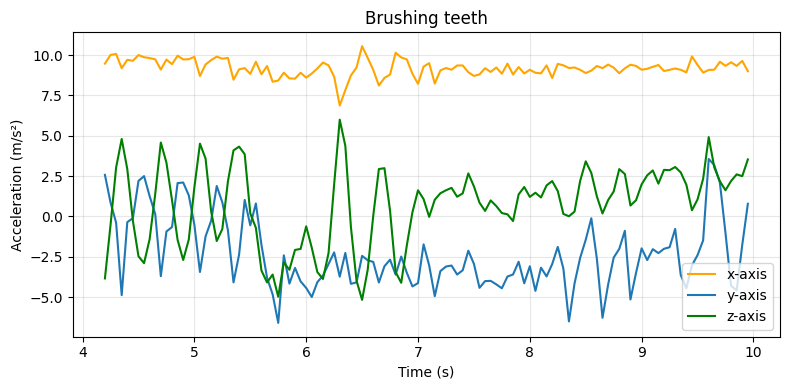

No user with >= 200 samples for activity D
Activity I (Eating chips), user 1605


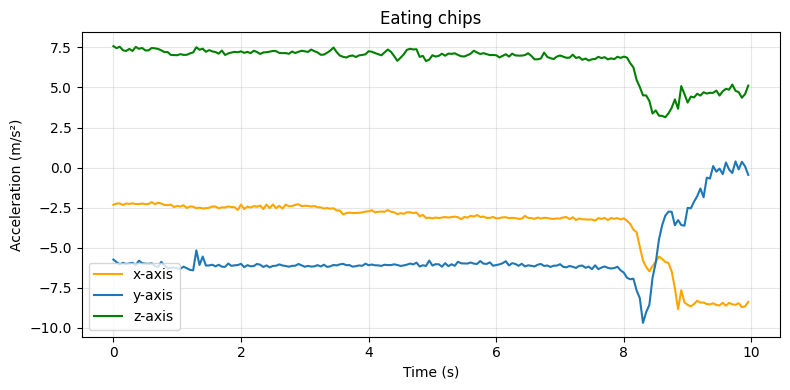

No user with >= 200 samples for activity W
Activity Q (Writing), user 1632


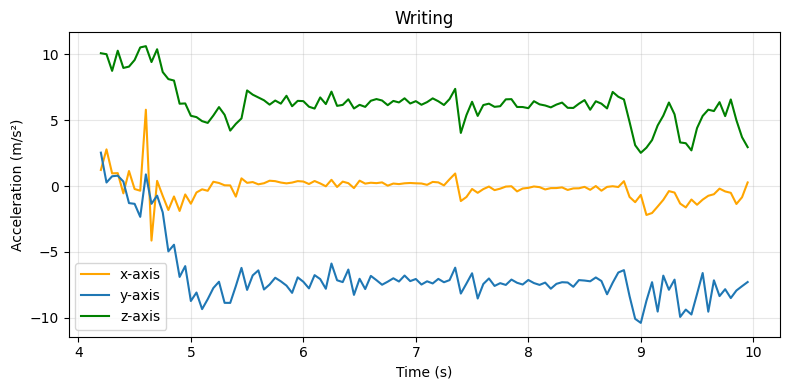

Activity F (Typing), user 1634


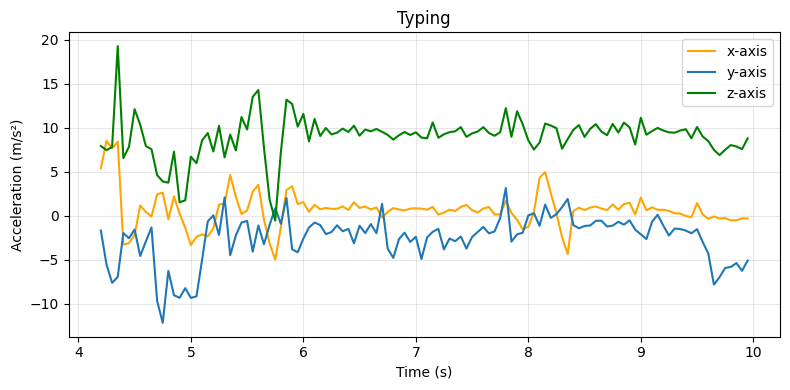

In [6]:
def pick_valid_users(df_src, activity_code):
    users = df_src[df_src["activity"] == activity_code]["user"].unique()
    valid = []
    for u in users:
        n = len(df_src[(df_src["user"] == u) &
                       (df_src["activity"] == activity_code)])
        if n >= WIN_N:
            valid.append(u)
    return valid


# --- G, D, I, W, Q, F ---
for code in ["G", "D", "I", "W", "Q", "F" ]:
    valid_users = pick_valid_users(df_hand, code)
    if not valid_users:
        print(f"No user with >= {WIN_N} samples for activity {code}")
        continue

    rand_user = np.random.choice(valid_users)
    print(f"Activity {code} ({activity_code2name[code]}), user {rand_user}")

    plot_middle_window(df_hand, rand_user, code)

# Task 3 – Signal Preprocessing (Hand Activity Recognition)

This notebook implements **Task 3: Signal Preprocessing** for the Hand Activity Recognition project using the raw WISDM files.

Goals:
- Handle missing data via interpolation and filling
- Apply a 4th-order Butterworth low-pass filter (noise reduction)
- Produce **before vs. after** plots of the signals
- Provide short narrative text that can be copied into the project report


In [7]:
# Sampling rate (WISDM watch/phone sensors)
FS = 20  # Hz

def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    """
    Apply a Butterworth low-pass filter to a 1D signal.

    Parameters
    ----------
    x : array-like
        Input time series.
    cutoff : float
        Cutoff frequency in Hz.
    fs : float
        Sampling rate in Hz.
    order : int
        Filter order.

    Returns
    -------
    y : np.ndarray
        Filtered signal.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)


In [8]:
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]
df_raw = df_hand.copy()

# Interpolate missing values and apply low-pass filter
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear")
    df_hand[col] = butter_lowpass_filter(df_hand[col].values)


Rows with this activity: 545602


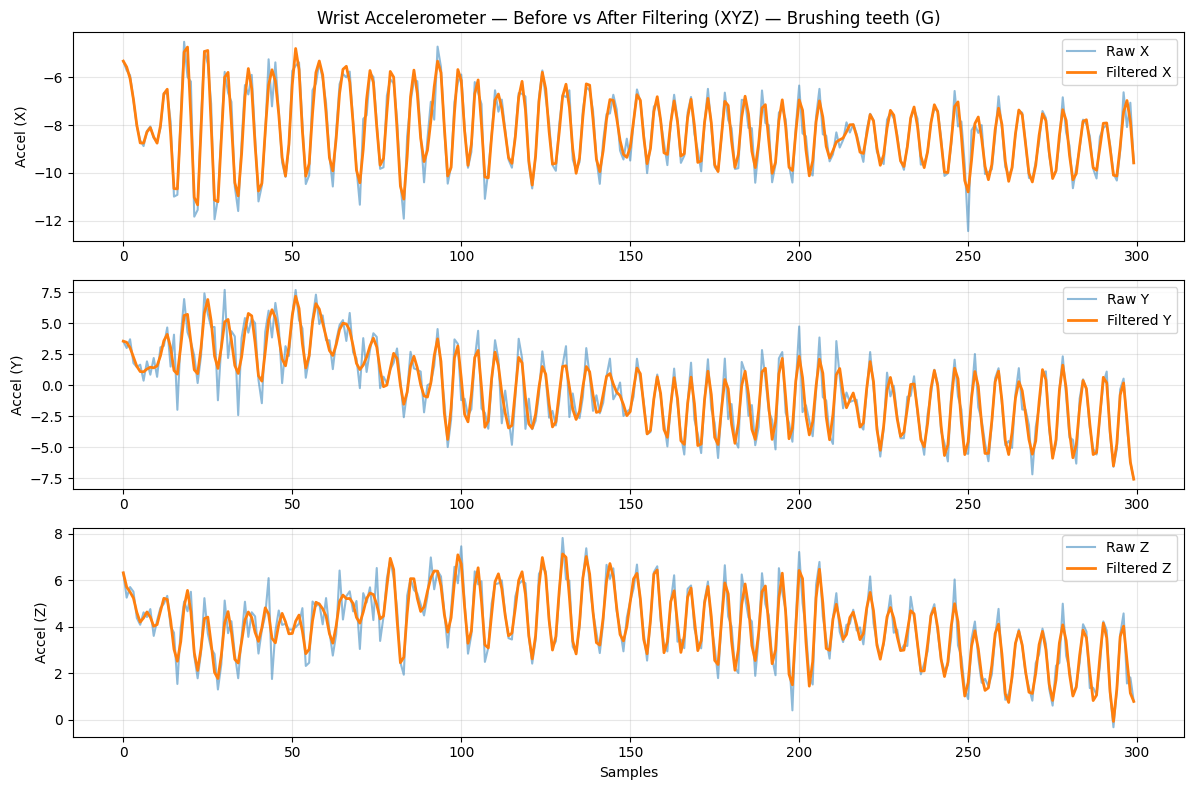

In [9]:
# --- choose one noisy activity ---
example_code = "G"
mask = df_hand["activity"] == example_code
print("Rows with this activity:", mask.sum())

if mask.sum() == 0:
    print("can not find activity", example_code)
    print("Activity:", df_hand["activity"].unique())
else:
    example_user = df_hand.loc[df_hand["activity"] == example_code, "user"].iloc[0]

    # Filtered dataframe
    df_f = df_hand[(df_hand["user"] == example_user) &
                   (df_hand["activity"] == example_code)].copy()

    # Raw dataframe
    df_r = df_raw[(df_raw["user"] == example_user) &
                  (df_raw["activity"] == example_code)].copy()

    # Select channel (first 300 samples) for X, Y, Z
    raw_x = df_r["w_acc_x"].values[:300]
    raw_y = df_r["w_acc_y"].values[:300]
    raw_z = df_r["w_acc_z"].values[:300]

    filt_x = butter_lowpass_filter(raw_x, cutoff=5, fs=FS)
    filt_y = butter_lowpass_filter(raw_y, cutoff=5, fs=FS)
    filt_z = butter_lowpass_filter(raw_z, cutoff=5, fs=FS)

    act_name = activity_code2name.get(example_code, example_code)

    # Plot X, Y, Z in stacked subplots
    plt.figure(figsize=(12, 8))

    # X-axis
    plt.subplot(3, 1, 1)
    plt.plot(raw_x, label="Raw X", alpha=0.5)
    plt.plot(filt_x, label="Filtered X", linewidth=2)
    plt.title(f"Wrist Accelerometer — Before vs After Filtering (XYZ) — {act_name} ({example_code})")
    plt.ylabel("Accel (X)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Y-axis
    plt.subplot(3, 1, 2)
    plt.plot(raw_y, label="Raw Y", alpha=0.5)
    plt.plot(filt_y, label="Filtered Y", linewidth=2)
    plt.ylabel("Accel (Y)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Z-axis
    plt.subplot(3, 1, 3)
    plt.plot(raw_z, label="Raw Z", alpha=0.5)
    plt.plot(filt_z, label="Filtered Z", linewidth=2)
    plt.xlabel("Samples")
    plt.ylabel("Accel (Z)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


## Narrative for Report (Task 3 – Signal Preprocessing)

Signal preprocessing is necessary because the raw accelerometer data contains sensor noise, high-frequency jitter, and occasional missing samples. We first applied linear interpolation to the X, Y, and Z accelerometer channels, followed by backward and forward filling when needed, to obtain a continuous time series without missing values.

To remove high-frequency noise while preserving meaningful motion patterns, we used a 4th-order Butterworth low-pass filter with a 5 Hz cutoff, based on the 20 Hz sampling rate of the WISDM dataset. The Butterworth design provides a maximally flat passband and, when applied with zero-phase filtering (`filtfilt`), avoids phase distortion that would otherwise shift or deform the activity waveforms.

The before-and-after plots show that the filtered signals are smoother and less noisy while retaining the overall amplitude and shape of the original motion trajectories. This preprocessing step improves the signal-to-noise ratio and prepares the data for subsequent windowing, feature extraction, and classification.
